# Investigating the Impact of Basis Quality on Leverage-Based Sample Selection

## Abstract

In this work, we study how basis quality influences leverage-based sample selection by comparing three classes of representations on MNIST: raw pixel features, random ReLU features, and convolutional neural networks with identical architectures but different random initializations. For each basis, we compute leverage scores and evaluate their effectiveness by training only on the top-k leverage points and measuring training accuracy as a function of k.

## Features

We consider three types of feature representations for the MNIST dataset:
1. **Raw Pixel Features**: The original pixel values of the images.
2. **Random ReLU Features**: Features generated by applying random ReLU transformations to the raw pixel data.
3. **Convolutional Neural Network (CNN) Features**: Features extracted from a CNN with the same architecture but different random initializations.
    - CNN A1-A5: Randomly initialized weights. Trained to do classification.
    - CNN B1-B5: Randomly initialized weights. Trained to do regression.
    - CNN C1-C5: Randomly initialized weights. Not trained.

## Investigations

### Question 1: How do different basises affect leverage-based sample selection?
1. **Leverage Score Computation**: For each feature representation, we compute the leverage scores of the training samples.
2. **Sample Selection**: We select the top-k samples based on their leverage scores.
3. **Model Training**: We train a classifier using only the selected top-k samples.
4. **Evaluation**: We evaluate the training accuracy as a function of k, the number of selected samples.

### Question 2: Do neural network prioritize the same samples across different random initializations? (In other words, are the leverage scores correlated across different random initializations? Is the idea of leverage score robust to random initialization?)

1. **Varying Basis Quality**: We systematically vary the quality of the basis by using different random initializations for the CNNs.
2. **Correlation Analysis**: We analyze the correlation of leverage scores across different random initializations to assess the robustness of leverage-based sample selection.
3. **Sample Overlap**: We measure the overlap in selected samples across different random initializations to understand if certain samples are consistently prioritized.

In [ ]:
import torch
import numpy as np
from mnist_embeddings import MnistConvNet


# Random ReLU Features
def relu_features(X, features=200) -> torch.Tensor:
    N, *_ = X.shape
    X = X.reshape(N, -1)
    W = torch.randn(X.shape[1], features, device=X.device)
    return torch.relu(X @ W) / np.sqrt(features)

from torchvision.datasets import MNIST


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", DEVICE)

MNIST_TRAIN = MNIST(root="~/Desktop/AliasingOperatorExperiments/data", train=True, download=True)
MNIST_TEST = MNIST(root="~/Desktop/AliasingOperatorExperiments/data", train=False, download=True)

mnist_X = (
    MNIST_TRAIN
    .data.float()
    .to(DEVICE)
    .reshape(-1, 1, 28, 28)
    / 255.0
)
mnist_y = MNIST_TRAIN.targets.to(DEVICE)
test_mnist_X = (
    MNIST_TEST
    .data.float()
    .to(DEVICE)
    .reshape(-1, 1, 28, 28)
    / 255.0
)
test_mnist_y = MNIST_TEST.targets.to(DEVICE)

combined_mnist_X = torch.cat([mnist_X, test_mnist_X], dim=0)
combined_mnist_y = torch.cat([mnist_y, test_mnist_y], dim=0)


import numpy as np
import torch

BASIS_FUNCTIONS = 200

# Embed the testing set (not the training set)
def embed_dataset(X, model, device, basics_functions=BASIS_FUNCTIONS):
    # Embed the data using the convolutional layers of the network
    embeddings = torch.tensor(
        np.zeros(
            (
                X.shape[0],
                basics_functions,
            )
        )
    ).to(device)

    with torch.no_grad():
        for batch_start in range(0, X.shape[0], 256):
            batch_end = min(batch_start + 256, X.shape[0])
            batch = X[batch_start:batch_end].to(device)
            batch_embeddings = model.embed(batch)
            embeddings[batch_start:batch_end] = batch_embeddings
    return embeddings


def load_model_embed_data(path: str):
    state = torch.load(path)
    net = MnistConvNet()
    net.load_state_dict(state['model_state_dict'])
    net.to(DEVICE)
    net.eval()
    embeddings = embed_dataset(combined_mnist_X, net, DEVICE, BASIS_FUNCTIONS)
    return embeddings

# Embeddings
LABELS = combined_mnist_y
RAW = combined_mnist_X.reshape(-1, 28 * 28)
RELU_FEATURES = relu_features(combined_mnist_X, features=RAW.shape[1])
CNN_EMBEDDINGS = {}

import glob
for path in glob.glob("cnn-*.pth"):
    _, letter, hsh = path[:-4].split("-")
    print("loading", path)
    CNN_EMBEDDINGS[letter] = load_model_embed_data(path)

using cpu
cnn-A2-84ffa0eefcbeeb657268917dd8bee109056e2999075e32338726351bb75c7b0b.pth
cnn-C1-c837d179d75114e9d075463863a69b3c29d89a6a5b58caf55ff0ca10db357247.pth
cnn-B1-3dfbc9921cd728dc8518b56f50277e7b06c5b1274287f0c423fb6d285234c61e.pth
cnn-A1-93d77c3a55680289cf891cc6aa9c777a4068913c3d94f6a12ca8e800343c4ed2.pth
cnn-A3-380064bbb68441c4a2d1846554f2eeef13008958975970e7128c168f9ecf3afe.pth
cnn-B2-d33ec18ec317ceb834e70900948cebf5349cd694b8e60c2fa01df671d884c6e9.pth
cnn-C3-3652111a96ee99a79ac7e9e46ee99ce32b8e23ff3049589268ece4248bbc0c84.pth
cnn-B4-fcfe370d0ff6a966c608170f43accb09c409c3f74c0bdf53a45c9885189810a8.pth
cnn-C2-5f0b018253844c6bc343087e0574368a8b3ba29212822abb485bca5491bc7305.pth
cnn-B5-279b4287f2a445aaaf5e5675d71f7598494df55d3e566aa6c7527516f14788e8.pth
cnn-C4-b0f6d55cba7a0bf5656a5177ee36bacfceefe3da2d6fc9ea7cb3f60d8ada3e1a.pth
cnn-A5-281c64ae0e093b5f25c74f563ab8df4816f691dac7192a6080025a1a5c5a5ea6.pth
cnn-B3-0a6871e7460a812e7ac48d7db52e642a0bf82cb6848e9c8b20f69cc4590697b8.pth
cn

In [6]:
def calculate_leverage_scores(X: torch.Tensor) -> torch.Tensor:
    """Calculate the leverage scores for the given data matrix X.

    Args:
        X (torch.Tensor): Data matrix of shape (N, D).
    Returns:
        torch.Tensor: Leverage scores of shape (N,).
    """
    Q, _ = torch.linalg.qr(X, mode="reduced")
    leverage_scores = torch.sum(Q ** 2, dim=1)
    return leverage_scores

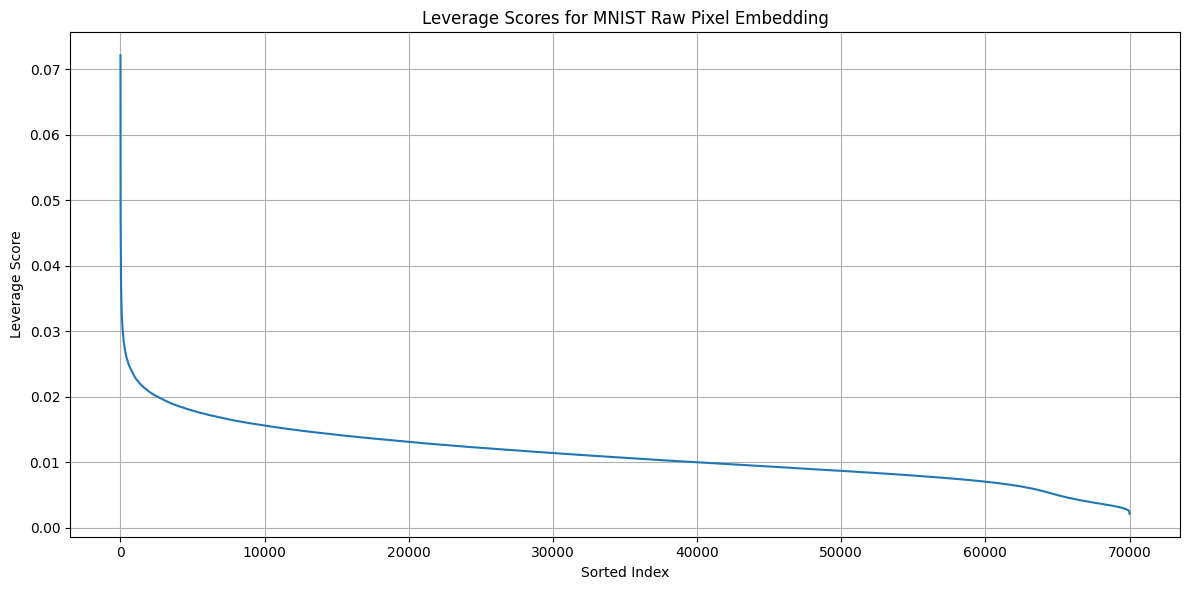

[   68    86   670   770   828  1190  1448  2032  2292  2324  2548  2773
  2880  2892  2900  3453  3466  3506  3572  3590  4728  4801  4841  4885
  4909  4952  5316  5384  6536  6898  7594  8178  8374  8668  8676  8826
  9261  9505  9552  9574 10038 10350 10524 10736 10924 10960 11304 11442
 11655 12332 12470 12707 12922 13040 13428 13538 13650 13712 13902 14174
 14376 14502 14613 14629 14649 14749 14790 15006 15088 15404 15592 15801
 15832 15848 16795 16834 16858 16888 16909 16977 16992 17048 17322 17542
 17595 17926 18398 18585 18632 18739 18788 19190 19298 19888 19934 19993
 20057 20098 20446 20786 21254 21772 22495 22621 22698 23594 24296 24582
 24616 24728 25055 25456 25986 26882 27010 27315 27328 27335 28030 28628
 29392 29472 29834 30133 30177 30638 31114 31173 31597 31624 31719 31745
 31776 31904 31921 32040 32192 32254 32348 32751 32930 33010 33150 33522
 34688 35750 35878 35885 36072 36508 36810 36866 36884 37074 37276 37382
 37788 38158 38716 38932 38936 38984 39316 39356 39

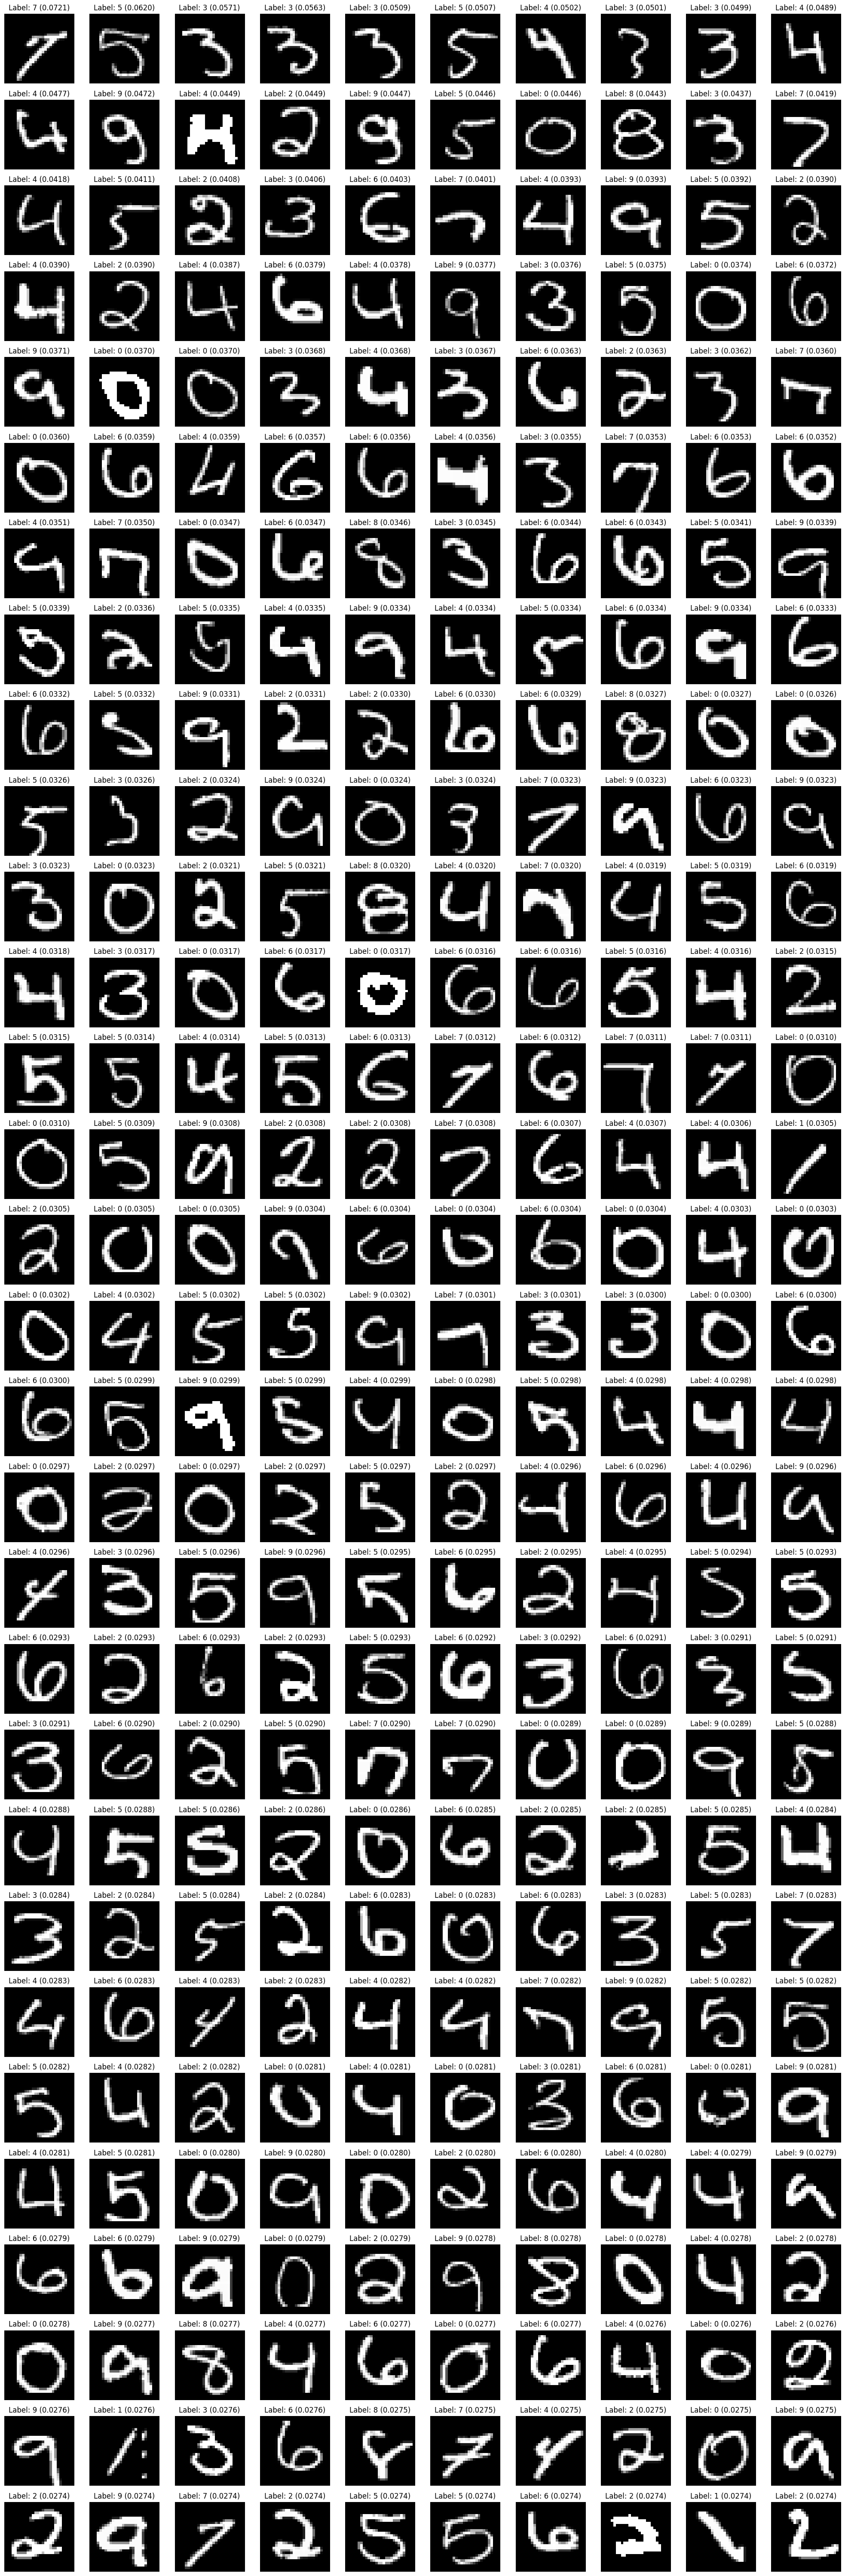

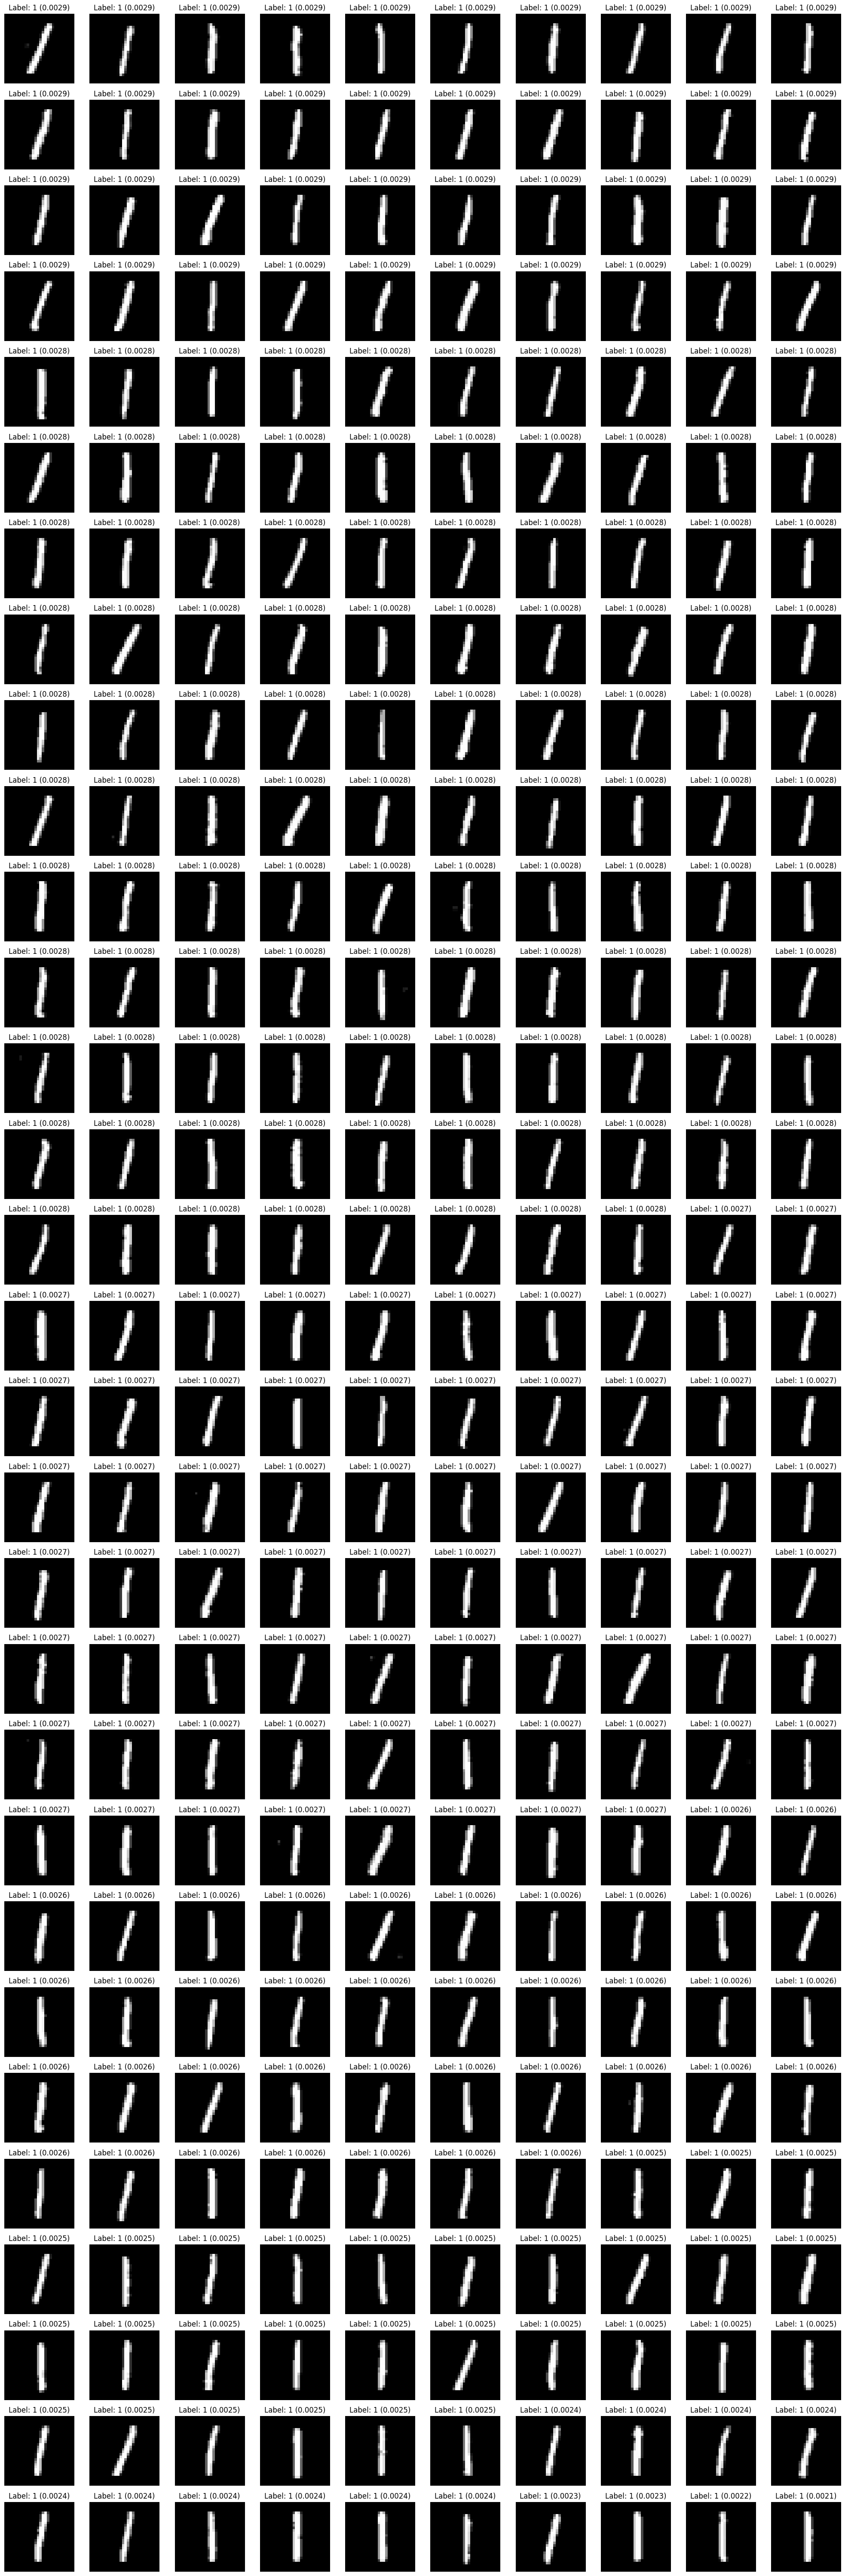

In [39]:
from matplotlib import pyplot as plt

embedding = RELU_FEATURES
leverage_scores = calculate_leverage_scores(embedding).cpu().numpy()

# Plot leverage score distribution
plt.figure(figsize=(12, 6))
plt.plot(np.sort(leverage_scores)[::-1])
plt.grid(True)
plt.title("Leverage Scores for MNIST Raw Pixel Embedding")
plt.xlabel("Sorted Index")
plt.ylabel("Leverage Score")
plt.tight_layout()
plt.show()

# Plot digits with highest leverage scores
fig_grid_width, fig_grid_height = 10, 30
fig = plt.figure(figsize=(fig_grid_width * 2, fig_grid_height * 2))
top_k = fig_grid_width * fig_grid_height
top_indices = np.argsort(leverage_scores)[-top_k:][::-1]
print(np.sort(top_indices))  # Save these for later!
for i, idx in enumerate(top_indices):
    ax = fig.add_subplot(fig_grid_height, fig_grid_width, i + 1)
    ax.imshow(combined_mnist_X[idx].cpu().squeeze(), cmap="gray")
    ax.set_title(f"Label: {combined_mnist_y[idx].item()} ({leverage_scores[idx]:.4f})")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Plot digits with lowest leverage scores
fig = plt.figure(figsize=(fig_grid_width * 2, fig_grid_height * 2))
bottom_k = fig_grid_width * fig_grid_height
bottom_indices = np.argsort(leverage_scores)[:bottom_k][::-1]
for i, idx in enumerate(bottom_indices):
    ax = fig.add_subplot(fig_grid_height, fig_grid_width, i + 1)
    ax.imshow(combined_mnist_X[idx].cpu().squeeze(), cmap="gray")
    ax.set_title(f"Label: {combined_mnist_y[idx].item()} ({leverage_scores[idx]:.4f})")
    ax.axis("off")

plt.tight_layout()
plt.show()